### Libraries

In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import itertools
import seaborn as sns

### Imbalanced data

In [2]:
# Read in data

t0 = time.time()
df = pd.read_csv('aggregate-20160501.csv')
t1 = time.time()
print(str((t1-t0)/60) + " minutes")

KeyboardInterrupt: 

In [3]:
#df.head()
#df.shape
#df.columns
#set(df.num_edits)

In [3]:
# Calculate percentage of unedited articles in original imbalanced data

len(df["num_edits"][df["num_edits"] == 0])/len(df["num_edits"])*100

99.91723664727162

In [5]:
# Check missingness in original imbalanced data

print(df.isnull().sum())

article_name                   1
num_edits                      0
views_30d                      0
views_7d                       0
views_3d                       0
views_1d                       0
edits_30d                      0
edits_7d                       0
edits_3d                       0
edits_1d                       0
minor_edits_30d                0
minor_edits_7d                 0
minor_edits_3d                 0
minor_edits_1d                 0
avg_size_30d             6428583
avg_size_7d             45268487
avg_size_3d             49800824
avg_size_1d             53028939
avg_size                  209968
latest_size               209968
talk_views_30d                 0
talk_views_7d                  0
talk_views_3d                  0
talk_views_1d                  0
talk_edits_30d                 0
talk_edits_7d                  0
talk_edits_3d                  0
talk_edits_1d                  0
talk_minor_edits_30d           0
talk_minor_edits_7d            0
talk_minor

In [4]:
# Generate binary edited vs. unedited variable

df['num_edits_binary'] = df['num_edits'].apply(lambda x: int(x > 0))
#set(df['num_edits_binary'])

In [5]:
# Store relevant variable names in a list

feature_names = [x for x in df.columns if 'num_edits' not in x and 'article_name' not in x]

label_name = "num_edits_binary"

feature_names

['views_30d',
 'views_7d',
 'views_3d',
 'views_1d',
 'edits_30d',
 'edits_7d',
 'edits_3d',
 'edits_1d',
 'minor_edits_30d',
 'minor_edits_7d',
 'minor_edits_3d',
 'minor_edits_1d',
 'avg_size_30d',
 'avg_size_7d',
 'avg_size_3d',
 'avg_size_1d',
 'avg_size',
 'latest_size',
 'talk_views_30d',
 'talk_views_7d',
 'talk_views_3d',
 'talk_views_1d',
 'talk_edits_30d',
 'talk_edits_7d',
 'talk_edits_3d',
 'talk_edits_1d',
 'talk_minor_edits_30d',
 'talk_minor_edits_7d',
 'talk_minor_edits_3d',
 'talk_minor_edits_1d',
 'talk_avg_size_30d',
 'talk_avg_size_7d',
 'talk_avg_size_3d',
 'talk_avg_size_1d',
 'talk_avg_size',
 'talk_latest_size']

### Balanced data

In [26]:
## Generate balanced sample

t0 = time.time()

np.random.seed(seed=13579)

# to be set aside as imbalanced test data
set1_idx = np.random.choice(range(len(df)), int(len(df) * .2), replace=False)
#set1_X = df.loc[set1_idx, feature_names]
#set1_Y = df.loc[set1_idx, label_name]
imbalanced_set = df.loc[set1_idx, df.columns]

# to be used to generate balanced data for main analysis
set2_idx = list(set(range(len(df))) - set(list(set1_idx)))
set2 = df.loc[set2_idx, list(df.columns.tolist())]

edited = set2[set2.num_edits > 0.0].copy(deep=True)
#edited.shape

not_edited = set2[set2.num_edits == 0.0].copy(deep=True)

not_edited_selected = not_edited[0:edited.shape[0]]

balanced_set = pd.concat([edited, not_edited_selected])

balanced_set = shuffle(balanced_set)
#balanced_set.shape

t1 = time.time()
print(str((t1-t0)/60) + " minutes")

3.287050557136536 minutes


In [27]:
print(edited.shape)
print(balanced_set.shape)
print(imbalanced_set.shape)

(20064, 39)
(40128, 39)
(6076844, 39)


In [25]:
balanced_set.head()

,article_name,num_edits,views_30d,views_7d,views_3d,views_1d,edits_30d,edits_7d,edits_3d,edits_1d,...,talk_minor_edits_7d,talk_minor_edits_3d,talk_minor_edits_1d,talk_avg_size_30d,talk_avg_size_7d,talk_avg_size_3d,talk_avg_size_1d,talk_avg_size,talk_latest_size,num_edits_binary
436966,2008_Indo-Pakistani_standoff,4.0,584.0,116.0,64.0,22.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,24439.250000,42476.000000,0.0,NaN,25051.578947,0.0,1
13520,04_hot_issue_kpop_dance_avi,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0
26361698,Henry_Guest,1.0,141.0,13.0,5.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,9490.250000,9494.000000,NaN,NaN,9491.000000,9494.0,1
17427554,English_As_She_Is_Spoke,1.0,2158.0,374.0,266.0,78.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,23773.888889,23771.666667,46798.0,NaN,25544.461538,46798.0,1
14169,100_Greatest_Britons,0.0,15950.0,3009.0,1271.0,544.0,10.0,0.0,0.0,0.0,...,0.0,0.0,0.0,64376.210526,56151.500000,34316.0,131406.0,64539.040000,131406.0,0


In [28]:
imbalanced_set.head()

,article_name,num_edits,views_30d,views_7d,views_3d,views_1d,edits_30d,edits_7d,edits_3d,edits_1d,...,talk_minor_edits_7d,talk_minor_edits_3d,talk_minor_edits_1d,talk_avg_size_30d,talk_avg_size_7d,talk_avg_size_3d,talk_avg_size_1d,talk_avg_size,talk_latest_size,num_edits_binary
6268408,Christian_Ludwig_Dieter,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0
1357280,Amphiporida,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0
3215831,Amplituner,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0
9281685,%E6%97%B6%E6%97%B6%E5%BD%A9%E5%8F%91%E5%B8%96%...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0
19040997,Dr_Oz_Weight_Loss_Diet_Supplements_Nv,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0


In [29]:
# Write imbalanced data to csv
#set1_X.to_csv('imbalanced_test_data.csv', sep=',')
#set1_Y.to_csv('imbalanced_test_labels.csv', sep=',')
imbalanced_set.to_csv('imbalanced_set_20160501.csv', sep=',')

# Write balanced data to csv

balanced_set.to_csv('balanced_set_20160501.csv', sep=',')
#balanced_set.head()

In [14]:
# Read in imbalanced data
#set1_X = pd.read_csv('imbalanced_test_data.csv')
#set1_Y = pd.read_csv('imbalanced_test_labels.csv')

df_imb = pd.read_csv('imbalanced_set_20160501.csv')
df_imb = df_imb.set_index('Unnamed: 0')
df_imb.index.name = None

# Read in balanced data

df_b = pd.read_csv('balanced_set_20160501.csv')
df_b = df_b.set_index('Unnamed: 0')
df_b.index.name = None
df_b.head()

,article_name,num_edits,views_30d,views_7d,views_3d,views_1d,edits_30d,edits_7d,edits_3d,edits_1d,...,talk_minor_edits_7d,talk_minor_edits_3d,talk_minor_edits_1d,talk_avg_size_30d,talk_avg_size_7d,talk_avg_size_3d,talk_avg_size_1d,talk_avg_size,talk_latest_size,num_edits_binary
436966,2008_Indo-Pakistani_standoff,4.0,584.0,116.0,64.0,22.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,24439.250000,42476.000000,0.0,NaN,25051.578947,0.0,1
13520,04_hot_issue_kpop_dance_avi,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0
26361698,Henry_Guest,1.0,141.0,13.0,5.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,9490.250000,9494.000000,NaN,NaN,9491.000000,9494.0,1
17427554,English_As_She_Is_Spoke,1.0,2158.0,374.0,266.0,78.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,23773.888889,23771.666667,46798.0,NaN,25544.461538,46798.0,1
14169,100_Greatest_Britons,0.0,15950.0,3009.0,1271.0,544.0,10.0,0.0,0.0,0.0,...,0.0,0.0,0.0,64376.210526,56151.500000,34316.0,131406.0,64539.040000,131406.0,0


In [31]:
# Calculate percentage of unedited articles in balanced data

len(df_b["num_edits_binary"][df_b["num_edits_binary"] == 0])/len(df_b["num_edits_binary"])*100

50.0

In [33]:
df_imb.head()

,article_name,num_edits,views_30d,views_7d,views_3d,views_1d,edits_30d,edits_7d,edits_3d,edits_1d,...,talk_minor_edits_7d,talk_minor_edits_3d,talk_minor_edits_1d,talk_avg_size_30d,talk_avg_size_7d,talk_avg_size_3d,talk_avg_size_1d,talk_avg_size,talk_latest_size,num_edits_binary
6268408,Christian_Ludwig_Dieter,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0
1357280,Amphiporida,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0
3215831,Amplituner,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0
9281685,%E6%97%B6%E6%97%B6%E5%BD%A9%E5%8F%91%E5%B8%96%...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0
19040997,Dr_Oz_Weight_Loss_Diet_Supplements_Nv,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0


In [34]:
# Calculate percentage of unedited articles in imbalanced data

len(df_imb["num_edits_binary"][df_imb["num_edits_binary"] == 0])/len(df_imb["num_edits_binary"])*100


99.91635460775363

In [35]:
# Check missingness in balanced data

print(df_b.isnull().sum())

article_name                  0
num_edits                     0
views_30d                     0
views_7d                      0
views_3d                      0
views_1d                      0
edits_30d                     0
edits_7d                      0
edits_3d                      0
edits_1d                      0
minor_edits_30d               0
minor_edits_7d                0
minor_edits_3d                0
minor_edits_1d                0
avg_size_30d                  0
avg_size_7d             4708325
avg_size_3d             5008947
avg_size_1d             5214553
avg_size                      0
latest_size                   0
talk_views_30d                0
talk_views_7d                 0
talk_views_3d                 0
talk_views_1d                 0
talk_edits_30d                0
talk_edits_7d                 0
talk_edits_3d                 0
talk_edits_1d                 0
talk_minor_edits_30d          0
talk_minor_edits_7d           0
talk_minor_edits_3d           0
talk_min

### New Features

In [3]:
# Generate features

# Views

def views_features(df_b):

    df_b['total_views'] = df_b.views_1d + df_b.views_3d + df_b.views_7d + df_b.views_30d

    # Version 1

    df_b['change_in_views_v1_7_30'] = df_b.views_7d/4 - df_b.views_30d/23

    df_b['change_in_views_v1_3_7'] = df_b.views_3d/2 - df_b.views_7d/4 

    df_b['change_in_views_v1_1_3'] = df_b.views_1d/1 - df_b.views_3d/2

    # Version 2

    df_b['change_in_views_v2_7_30'] = ((df_b.views_7d/4)+1)/((df_b.views_30d/23)+1)

    df_b['change_in_views_v2_3_7'] = ((df_b.views_3d/2)+1)/((df_b.views_7d/4)+1)

    df_b['change_in_views_v2_1_3'] = ((df_b.views_1d/1)+1)/((df_b.views_3d/2)+1)

    return df_b


df_b = views_features(df_b)
df_imb = views_features(df_imb)
#df_b['total_views'].describe()

In [4]:
# Edits

def edit_features(df_b):
    
    df_b['total_edits'] = df_b.edits_1d + df_b.edits_3d + df_b.edits_7d + df_b.edits_30d

    # Version 1

    df_b['change_in_edits_v1_7_30'] = df_b.edits_7d/4 - df_b.edits_30d/23

    df_b['change_in_edits_v1_3_7'] = df_b.edits_3d/2 - df_b.edits_7d/4

    df_b['change_in_edits_v1_1_3'] = df_b.edits_1d/1 - df_b.edits_3d/2

    # Version 2

    df_b['change_in_edits_v2_7_30'] = ((df_b.edits_7d/4)+1)/((df_b.edits_30d/23)+1)

    df_b['change_in_edits_v2_3_7'] = ((df_b.edits_3d/2)+1)/((df_b.edits_7d/4)+1)

    df_b['change_in_edits_v2_1_3'] = ((df_b.edits_1d/1)+1)/((df_b.edits_3d/2)+1)
    
    return df_b

df_b = edit_features(df_b)
df_imb = edit_features(df_imb)
#df_b['total_edits'].describe()

In [ ]:
# Minor edits

def minor_edits_features(df_b):
    df_b['total_minor_edits'] = df_b.minor_edits_1d + df_b.minor_edits_3d + df_b.minor_edits_7d + df_b.minor_edits_30d

    # Version 1

    df_b['change_in_minor_edits_v1_7_30'] = df_b.minor_edits_7d/4 - df_b.minor_edits_30d/23

    df_b['change_in_minor_edits_v1_3_7'] = df_b.minor_edits_3d/2 - df_b.minor_edits_7d/4

    df_b['change_in_minor_edits_v1_1_3'] = df_b.minor_edits_1d/1 - df_b.minor_edits_3d/2

    # Version 2

    df_b['change_in_minor_edits_v2_7_30'] = ((df_b.minor_edits_7d/4)+1)/((df_b.minor_edits_30d/23)+1)

    df_b['change_in_minor_edits_v2_3_7'] = ((df_b.minor_edits_3d/2)+1)/((df_b.minor_edits_7d/4)+1)

    df_b['change_in_minor_edits_v2_1_3'] = ((df_b.minor_edits_1d/1)+1)/((df_b.minor_edits_3d/2)+1)
    return df_b

df_b = minor_edits_features(df_b)
df_imb = minor_edits_features(df_imb)
#df_b['total_minor_edits'].describe()

In [5]:
# Average size

def ave_size_features(df_b):
    # Version 1

    df_b['change_in_avg_size_v1_7_30'] = df_b[['avg_size_7d', 'avg_size_30d', 'edits_7d', 'edits_30d']].apply(
        lambda x: 0
        if (x['edits_7d'] + x['edits_30d'] == 0)
        else (x['avg_size_7d']/4 - x['avg_size_30d']/23), 
        axis=1
    )

    df_b['change_in_avg_size_v1_3_7'] = df_b[['avg_size_3d', 'avg_size_7d', 'edits_3d', 'edits_7d']].apply(
        lambda x: 0
        if (x['edits_3d'] + x['edits_7d'] == 0)
        else (x['avg_size_3d']/2 - x['avg_size_7d']/4), 
        axis=1
    )

    df_b['change_in_avg_size_v1_1_3'] = df_b[['avg_size_1d', 'avg_size_3d', 'edits_1d', 'edits_3d']].apply(
        lambda x: 0
        if (x['edits_1d'] + x['edits_3d'] == 0)
        else (x['avg_size_1d']/1 - x['avg_size_3d']/2), 
        axis=1
    )

    # Version 2

    df_b['change_in_avg_size_v2_7_30'] = df_b[['avg_size_7d', 'avg_size_30d', 'edits_7d', 'edits_30d']].apply(
        lambda x: 0
        if (x['edits_7d'] + x['edits_30d'] == 0)
        else (((x['avg_size_7d']/4)+1)/((x['avg_size_30d']/23)+1)), 
        axis=1
    )

    df_b['change_in_avg_size_v2_3_7'] = df_b[['avg_size_3d', 'avg_size_7d', 'edits_3d', 'edits_7d']].apply(
        lambda x: 0
        if (x['edits_3d'] + x['edits_7d'] == 0)
        else (((x['avg_size_3d']/2)+1)/((x['avg_size_7d']/4)+1)), 
        axis=1
    )

    df_b['change_in_avg_size_v2_1_3'] = df_b[['avg_size_1d', 'avg_size_3d', 'edits_1d', 'edits_3d']].apply(
        lambda x: 0
        if (x['edits_1d'] + x['edits_3d'] == 0)
        else (((x['avg_size_1d']/1)+1)/((x['avg_size_3d']/2)+1)), 
        axis=1
    )
    return df_b

df_b = ave_size_features(df_b)
df_imb = ave_size_features(df_imb)
#df_b['change_in_avg_size_v2_1_3'].describe()

In [18]:
# Talk views

def talk_views_features(df_b):
    df_b['total_talk_views'] = df_b.talk_views_1d + df_b.talk_views_3d + df_b.talk_views_7d + df_b.talk_views_30d

    # Version 1

    df_b['change_in_talk_views_v1_7_30'] = df_b.talk_views_7d/4 - df_b.talk_views_30d/23

    df_b['change_in_talk_views_v1_3_7'] = df_b.talk_views_3d/2 - df_b.talk_views_7d/4 

    df_b['change_in_talk_views_v1_1_3'] = df_b.talk_views_1d/1 - df_b.talk_views_3d/2

    # Version 2

    df_b['change_in_talk_views_v2_7_30'] = ((df_b.talk_views_7d/4)+1)/((df_b.talk_views_30d/23)+1)

    df_b['change_in_talk_views_v2_3_7'] = ((df_b.talk_views_3d/2)+1)/((df_b.talk_views_7d/4)+1)

    df_b['change_in_talk_views_v2_1_3'] = ((df_b.talk_views_1d/1)+1)/((df_b.talk_views_3d/2)+1)
    return df_b

df_b = talk_views_features(df_b)
df_imb = talk_views_features(df_imb)
#df_b['total_talk_views'].describe()

In [6]:
# Talk edits

def talk_edits_features(df_b):
    
    df_b['total_talk_edits'] = df_b.talk_edits_1d + df_b.talk_edits_3d + df_b.talk_edits_7d + df_b.talk_edits_30d

    # Version 1

    df_b['change_in_talk_edits_v1_7_30'] = df_b.talk_edits_7d/4 - df_b.talk_edits_30d/23

    df_b['change_in_talk_edits_v1_3_7'] = df_b.talk_edits_3d/2 - df_b.talk_edits_7d/4

    df_b['change_in_talk_edits_v1_1_3'] = df_b.talk_edits_1d/1 - df_b.talk_edits_3d/2

    # Version 2

    df_b['change_in_talk_edits_v2_7_30'] = ((df_b.talk_edits_7d/4)+1)/((df_b.talk_edits_30d/23)+1)

    df_b['change_in_talk_edits_v2_3_7'] = ((df_b.talk_edits_3d/2)+1)/((df_b.talk_edits_7d/4)+1)

    df_b['change_in_talk_edits_v2_1_3'] = ((df_b.talk_edits_1d/1)+1)/((df_b.talk_edits_3d/2)+1)
    return df_b

df_b = talk_edits_features(df_b)
df_imb = talk_edits_features(df_imb)
#df_b['total_talk_edits'].describe()

In [20]:
# Talk minor edits

def talk_minor_edits(df_b):
    
    df_b['total_talk_minor_edits'] = (df_b.talk_minor_edits_1d + df_b.talk_minor_edits_3d + 
                                      df_b.talk_minor_edits_7d + df_b.talk_minor_edits_30d)

    # Version 1

    df_b['change_in_talk_minor_edits_v1_7_30'] = df_b.talk_minor_edits_7d/4 - df_b.talk_minor_edits_30d/23

    df_b['change_in_talk_minor_edits_v1_3_7'] = df_b.talk_minor_edits_3d/2 - df_b.talk_minor_edits_7d/4

    df_b['change_in_talk_minor_edits_v1_1_3'] = df_b.talk_minor_edits_1d/1 - df_b.talk_minor_edits_3d/2

    # Version 2

    df_b['change_in_talk_minor_edits_v2_7_30'] = ((df_b.talk_minor_edits_7d/4)+1)/((df_b.talk_minor_edits_30d/23)+1)

    df_b['change_in_talk_minor_edits_v2_3_7'] = ((df_b.talk_minor_edits_3d/2)+1)/((df_b.talk_minor_edits_7d/4)+1)

    df_b['change_in_talk_minor_edits_v2_1_3'] = ((df_b.talk_minor_edits_1d/1)+1)/((df_b.talk_minor_edits_3d/2)+1)
    return df_b

df_b = talk_minor_edits(df_b)
df_imb = talk_minor_edits(df_imb)
#df_b['total_talk_minor_edits'].describe()

In [7]:
# Talk average size

def talk_ave_size(df_b):
    
    # Version 1

    df_b['change_in_talk_avg_size_v1_7_30'] = df_b[['talk_avg_size_7d', 'talk_avg_size_30d', 
                                                    'talk_edits_7d', 'talk_edits_30d']].apply(
        lambda x: 0
        if (x['talk_edits_7d'] + x['talk_edits_30d'] == 0)
        else (x['talk_avg_size_7d']/4 - x['talk_avg_size_30d']/23), 
        axis=1
    )

    df_b['change_in_talk_avg_size_v1_3_7'] = df_b[['talk_avg_size_3d', 'talk_avg_size_7d', 
                                                   'talk_edits_3d', 'talk_edits_7d']].apply(
        lambda x: 0
        if (x['talk_edits_3d'] + x['talk_edits_7d'] == 0)
        else (x['talk_avg_size_3d']/2 - x['talk_avg_size_7d']/4), 
        axis=1
    )

    df_b['change_in_talk_avg_size_v1_1_3'] = df_b[['talk_avg_size_1d', 'talk_avg_size_3d', 
                                                   'talk_edits_1d', 'talk_edits_3d']].apply(
        lambda x: 0
        if (x['talk_edits_1d'] + x['talk_edits_3d'] == 0)
        else (x['talk_avg_size_1d']/1 - x['talk_avg_size_3d']/2), 
        axis=1
    )

    # Version 2

    df_b['change_in_talk_avg_size_v2_7_30'] = df_b[['talk_avg_size_7d', 'talk_avg_size_30d', 
                                                    'talk_edits_7d', 'talk_edits_30d']].apply(
        lambda x: 0
        if (x['talk_edits_7d'] + x['talk_edits_30d'] == 0)
        else (((x['talk_avg_size_7d']/4)+1)/((x['talk_avg_size_30d']/23)+1)), 
        axis=1
    )

    df_b['change_in_talk_avg_size_v2_3_7'] = df_b[['talk_avg_size_3d', 'talk_avg_size_7d', 
                                                   'talk_edits_3d', 'talk_edits_7d']].apply(
        lambda x: 0
        if (x['talk_edits_3d'] + x['talk_edits_7d'] == 0)
        else (((x['talk_avg_size_3d']/2)+1)/((x['talk_avg_size_7d']/4)+1)), 
        axis=1
    )

    df_b['change_in_talk_avg_size_v2_1_3'] = df_b[['talk_avg_size_1d', 'talk_avg_size_3d', 
                                                   'talk_edits_1d', 'talk_edits_3d']].apply(
        lambda x: 0
        if (x['talk_edits_1d'] + x['talk_edits_3d'] == 0)
        else (((x['talk_avg_size_1d']/1)+1)/((x['talk_avg_size_3d']/2)+1)), 
        axis=1
    )
    return df_b

df_b = talk_ave_size(df_b)
df_imb = talk_ave_size(df_imb)
#df_b['change_in_talk_avg_size_v2_1_3'].describe()

In [9]:
# Check missingness in balanced data with new features

print(df_b.isnull().sum())

article_name                             0
num_edits                                0
views_30d                                0
views_7d                                 0
views_3d                                 0
views_1d                                 0
edits_30d                                0
edits_7d                                 0
edits_3d                                 0
edits_1d                                 0
minor_edits_30d                          0
minor_edits_7d                           0
minor_edits_3d                           0
minor_edits_1d                           0
avg_size_30d                             0
avg_size_7d                        4708325
avg_size_3d                        5008947
avg_size_1d                        5214553
avg_size                                 0
latest_size                              0
talk_views_30d                           0
talk_views_7d                            0
talk_views_3d                            0
talk_views_

In [13]:
df_b.shape

(40128, 72)

In [10]:
# Write imbalanced and balanced data (with new features) to csv

df_b.to_csv('balanced_set2_20160501.csv', sep=',')
df_imb.to_csv('imbalanced_set2_20160501.csv', sep=',')
#df_b.head()

In [3]:
# Read in imbalanced and balanced data (with new features)

df_b2 = pd.read_csv('balanced_set2_20160501.csv')
df_b2 = df_b2.set_index('Unnamed: 0')
df_b2.index.name = None
print(df_b2.shape)

df_imb2 = pd.read_csv('imbalanced_set2_20160501.csv')
df_imb2 = df_imb2.set_index('Unnamed: 0')
df_imb2.index.name = None
print(df_imb2.shape)

#df_b2.head()

(40128, 72)
(6076844, 72)


In [4]:
df_b2_reset_index = df_b2.reset_index()
df_b2_reset_index = df_b2_reset_index.rename(columns={'index': 'original_index'})
print(df_b2_reset_index.shape)

df_imb2_reset_index = df_imb2.reset_index()
df_imb2_reset_index = df_imb2_reset_index.rename(columns={'index': 'original_index'})
print(df_imb2_reset_index.shape)

#df_b2_reset_index.head()


(40128, 73)
(6076844, 73)


In [5]:
# Store relevant variable names (including new features) in a list

new_feature_names = [x for x in df_b2_reset_index.columns 
                     if 'original_index' not in x
                     and 'article_name' not in x
                     and 'num_edits' not in x
                     and 'views_30d' not in x
                     and 'views_7d' not in x
                     and 'views_3d' not in x
                     and 'views_1d' not in x
                     and 'edits_30d' not in x
                     and 'edits_7d' not in x
                     and 'edits_3d' not in x
                     and 'edits_1d' not in x
                     and 'minor_edits_30d' not in x
                     and 'minor_edits_7d' not in x
                     and 'minor_edits_3d' not in x
                     and 'minor_edits_1d' not in x
                     and 'avg_size_30d' not in x
                     and 'avg_size_7d' not in x
                     and 'avg_size_3d' not in x
                     and 'avg_size_1d' not in x
                     and 'talk_views_30d' not in x
                     and 'talk_views_7d' not in x
                     and 'talk_views_3d' not in x
                     and 'talk_views_1d' not in x
                     and 'talk_edits_30d' not in x
                     and 'talk_edits_7d' not in x
                     and 'talk_edits_3d' not in x
                     and 'talk_edits_1d' not in x
                     and 'talk_minor_edits_30d' not in x
                     and 'talk_minor_edits_7d' not in x
                     and 'talk_minor_edits_3d' not in x
                     and 'talk_minor_edits_1d' not in x
                     and 'talk_avg_size_30d' not in x
                     and 'talk_avg_size_7d' not in x
                     and 'talk_avg_size_3d' not in x
                     and 'talk_avg_size_1d' not in x
                     and 'talk_avg_size' not in x
                     and 'talk_latest_size' not in x]

print(len(new_feature_names))

label_name = "num_edits_binary"

29


In [6]:
# Drop rows with NaN's 

df_b2_ri = df_b2_reset_index[new_feature_names + [label_name]]
df_b2_ri = df_b2_ri.dropna() 

df_b2_ri = df_b2_ri.reset_index()
df_b2_ri = df_b2_ri.drop('index', 1)

print(df_b2_ri.shape)

# same for imbalanced set
df_imb2_ri = df_imb2_reset_index[new_feature_names + [label_name]]
df_imb2_ri = df_imb2_ri.dropna() 

df_imb2_ri = df_imb2_ri.reset_index()
df_imb2_ri = df_imb2_ri.drop('index', 1)

print(df_imb2_ri.shape)

(39962, 30)
(6070808, 30)


In [8]:
df_imb2_ri.isnull().sum()

avg_size                        0
latest_size                     0
total_views                     0
change_in_views_v1_7_30         0
change_in_views_v1_3_7          0
change_in_views_v1_1_3          0
change_in_views_v2_7_30         0
change_in_views_v2_3_7          0
change_in_views_v2_1_3          0
total_edits                     0
change_in_edits_v1_7_30         0
change_in_edits_v1_3_7          0
change_in_edits_v1_1_3          0
change_in_edits_v2_7_30         0
change_in_edits_v2_3_7          0
change_in_edits_v2_1_3          0
change_in_avg_size_v1_7_30      0
change_in_avg_size_v1_3_7       0
change_in_avg_size_v1_1_3       0
change_in_avg_size_v2_7_30      0
change_in_avg_size_v2_3_7       0
change_in_avg_size_v2_1_3       0
total_talk_edits                0
change_in_talk_edits_v1_7_30    0
change_in_talk_edits_v1_3_7     0
change_in_talk_edits_v1_1_3     0
change_in_talk_edits_v2_7_30    0
change_in_talk_edits_v2_3_7     0
change_in_talk_edits_v2_1_3     0
num_edits_bina

In [11]:
print("For balanced data set")
print("Number of unedited articles: ", len(df_b2_ri[df_b2_ri.num_edits_binary == 0])) # number of unedited articles
print("Number of edited articles: ", len(df_b2_ri[df_b2_ri.num_edits_binary != 0])) # number of edited articles

print("\nFor imbalanced data set")
print("Number of unedited articles: ", len(df_imb2_ri[df_imb2_ri.num_edits_binary == 0])) # number of unedited articles
print("Number of edited articles: ", len(df_imb2_ri[df_imb2_ri.num_edits_binary != 0])) # number of edited articles

For balanced data set
Number of unedited articles:  20059
Number of edited articles:  19903

For imbalanced data set
Number of unedited articles:  6065767
Number of edited articles:  5041


In [12]:
# Normalize features

def normalize(raw_data):
    mean = np.mean(raw_data)
    sd = np.std(raw_data)
    normalized_data = (raw_data-mean)/sd
    return normalized_data

In [13]:
features = list(set(df_b2_ri.columns.tolist()) - set(['num_edits_binary']))

df_b2_ri_n = df_b2_ri.copy(deep=True)
df_imb2_ri_n = df_imb2_ri.copy(deep=True)

for f in features:
    df_b2_ri_n[f] = normalize(df_b2_ri_n[f])
    df_imb2_ri_n[f] = normalize(df_imb2_ri_n[f])
    
#df_b2_ri_n.head()

In [14]:
# Convert data frame to matrix

X = df_b2_ri_n[new_feature_names].as_matrix()
X_nn = df_b2_ri[new_feature_names].as_matrix()

Y = df_b2_ri_n[label_name].as_matrix()
Y_nn = df_b2_ri[label_name].as_matrix()

In [19]:
# do the same with imbalanced set

imb_X = df_imb2_ri_n[new_feature_names].as_matrix()
imb_Y = df_imb2_ri_n[label_name].as_matrix()



### Correlation matrix

In [34]:
corr_table = df_b2_ri_n[[label_name] + new_feature_names].corr(method='pearson')
corr_table.style.background_gradient(cmap='RdYlGn', axis = 0)

## Multi-model exploration: fitting, testing, metrics comparison, feature importance

### Models

In [15]:
# Logistic regression

np.random.seed(seed=13579)

kf = KFold(n_splits=5, random_state=13579)

logit_test_acc = []
logit_test_precision = []
logit_test_recall = []
logit_test_roc_auc = []

t0 = time.time()
for train_idx, test_idx in kf.split(X):
    train_x = X[train_idx]
    train_y = Y[train_idx]
    test_x = X[test_idx]
    test_y = Y[test_idx]

    logit = LogisticRegression()
    logit.fit(train_x, train_y)
    
    y_pred_test = logit.predict(test_x)
    
    logit_test_acc += [accuracy_score(test_y, y_pred_test)]
    logit_test_precision += [precision_score(test_y, y_pred_test)]
    logit_test_recall += [recall_score(test_y, y_pred_test)]
    logit_test_roc_auc += [roc_auc_score(test_y, y_pred_test)]

t1 = time.time()
logit_time_taken = t1-t0

print("Time taken is: " + str(logit_time_taken/60) + " minutes")
print("Test accuracy is: " + str(np.mean(logit_test_acc)))
print("Test precision is: " + str(np.mean(logit_test_precision)))
print("Test recall is: " + str(np.mean(logit_test_recall)))
print("Test ROC AUC is: " + str(np.mean(logit_test_roc_auc)))

Time taken is: 0.15978423754374185 minutes
Test accuracy is: 0.709374002427
Test precision is: 0.830893819475
Test recall is: 0.522845001854
Test ROC AUC is: 0.70865546223


In [16]:
# Decision tree

np.random.seed(seed=13579)

kf = KFold(n_splits=5, random_state=13579)

tree_test_acc = []
tree_test_precision = []
tree_test_recall = []
tree_test_roc_auc = []

t0 = time.time()
for train_idx, test_idx in kf.split(X):
    train_x = X[train_idx]
    train_y = Y[train_idx]
    test_x = X[test_idx]
    test_y = Y[test_idx]

    tree = DecisionTreeClassifier(random_state=13579, max_depth=18)
    tree.fit(train_x, train_y)
    
    y_pred_test = tree.predict(test_x)
    
    tree_test_acc += [accuracy_score(test_y, y_pred_test)]
    tree_test_precision += [precision_score(test_y, y_pred_test)]
    tree_test_recall += [recall_score(test_y, y_pred_test)]
    tree_test_roc_auc += [roc_auc_score(test_y, y_pred_test)]
    
t1 = time.time()
tree_time_taken = t1-t0

print("Time taken is: " + str(tree_time_taken/60) + " minutes")
print("Test accuracy is: " + str(np.mean(tree_test_acc)))
print("Test precision is: " + str(np.mean(tree_test_precision)))
print("Test recall is: " + str(np.mean(tree_test_recall)))
print("Test ROC AUC is: " + str(np.mean(tree_test_roc_auc)))

Time taken is: 0.06121551593144735 minutes
Test accuracy is: 0.728116700461
Test precision is: 0.731912920402
Test recall is: 0.716550283207
Test ROC AUC is: 0.728066152311


In [17]:
# LASSO

np.random.seed(seed=13579)

kf = KFold(n_splits=5, random_state=13579)

lasso_test_acc = []
lasso_test_precision = []
lasso_test_recall = []
lasso_test_roc_auc = []

t0 = time.time()
for train_idx, test_idx in kf.split(X):
    train_x = X[train_idx]
    train_y = Y[train_idx]
    test_x = X[test_idx]
    test_y = Y[test_idx]

    lasso = LogisticRegression(penalty = 'l1')
    lasso.fit(train_x, train_y)
    
    y_pred_test = lasso.predict(test_x)
    
    lasso_test_acc += [accuracy_score(test_y, y_pred_test)]
    lasso_test_precision += [precision_score(test_y, y_pred_test)]
    lasso_test_recall += [recall_score(test_y, y_pred_test)]
    lasso_test_roc_auc += [roc_auc_score(test_y, y_pred_test)]

t1 = time.time()
lasso_time_taken = t1-t0

print("Time taken is: " + str(lasso_time_taken/60) + " minutes")
print("Test accuracy is: " + str(np.mean(lasso_test_acc)))
print("Test precision is: " + str(np.mean(lasso_test_precision)))
print("Test recall is: " + str(np.mean(lasso_test_recall)))
print("Test ROC AUC is: " + str(np.mean(lasso_test_roc_auc)))

KeyboardInterrupt: 

In [42]:
# K-nearest neighbors

np.random.seed(seed=13579)

kf = KFold(n_splits=5, random_state=13579)

knn_test_acc = []
knn_test_precision = []
knn_test_recall = []
knn_test_roc_auc = []

t0 = time.time()
for train_idx, test_idx in kf.split(X):
    train_x = X[train_idx]
    train_y = Y[train_idx]
    test_x = X[test_idx]
    test_y = Y[test_idx]
    
    knn = KNeighborsClassifier()
    knn.fit(train_x, train_y)
    
    y_pred_test = knn.predict(test_x)
    
    knn_test_acc += [accuracy_score(test_y, y_pred_test)]
    knn_test_precision += [precision_score(test_y, y_pred_test)]
    knn_test_recall += [recall_score(test_y, y_pred_test)]
    knn_test_roc_auc += [roc_auc_score(test_y, y_pred_test)]
    
t1 = time.time()
knn_time_taken = t1-t0
    
print("Time taken is: " + str(knn_time_taken/60) + " minutes")
print("Test accuracy is: " + str(np.mean(knn_test_acc)))
print("Test precision is: " + str(np.mean(knn_test_precision)))
print("Test recall is: " + str(np.mean(knn_test_recall)))
print("Test ROC AUC is: " + str(np.mean(knn_test_roc_auc)))

Time taken is: 3.493733735879262 minutes
Test accuracy is: 0.680454999107
Test precision is: 0.685862821336
Test recall is: 0.654834635854
Test ROC AUC is: 0.680217249777


In [39]:
# Random forest

np.random.seed(seed=13579)

kf = KFold(n_splits=5, random_state=13579)

forest_test_acc = []
forest_test_precision = []
forest_test_recall = []
forest_test_roc_auc = []

t0 = time.time()
for train_idx, test_idx in kf.split(X):
    train_x = X[train_idx]
    train_y = Y[train_idx]
    test_x = X[test_idx]
    test_y = Y[test_idx]

    forest = RandomForestClassifier(random_state=13579, max_depth=18)
    forest.fit(train_x, train_y)
    
    y_pred_test = forest.predict(test_x)

    forest_test_acc += [accuracy_score(test_y, y_pred_test)]
    forest_test_precision += [precision_score(test_y, y_pred_test)]
    forest_test_recall += [recall_score(test_y, y_pred_test)]
    forest_test_roc_auc += [roc_auc_score(test_y, y_pred_test)]

t1 = time.time()
forest_time_taken = t1-t0

print("Time taken is: " + str(forest_time_taken/60) + " minutes")
print("Test accuracy is: " + str(np.mean(forest_test_acc)))
print("Test precision is: " + str(np.mean(forest_test_precision)))
print("Test recall is: " + str(np.mean(forest_test_recall)))
print("Test ROC AUC is: " + str(np.mean(forest_test_roc_auc)))

Time taken is: 0.10418534676233927 minutes
Test accuracy is: 0.77916834208
Test precision is: 0.780619675578
Test recall is: 0.770834443973
Test ROC AUC is: 0.779094241499


In [43]:
# Multi-layer perceptron

np.random.seed(seed=13579)

kf = KFold(n_splits=5, random_state=13579)

tron_test_acc = []
tron_test_precision = []
tron_test_recall = []
tron_test_roc_auc = []

t0 = time.time()
for train_idx, test_idx in kf.split(X):
    train_x = X[train_idx]
    train_y = Y[train_idx]
    test_x = X[test_idx]
    test_y = Y[test_idx]

    tron = MLPClassifier(solver='lbfgs', random_state=13579)
    tron.fit(train_x, train_y)
    
    y_pred_test = tron.predict(test_x)
    
    tron_test_acc += [accuracy_score(test_y, y_pred_test)]
    tron_test_precision += [precision_score(test_y, y_pred_test)]
    tron_test_recall += [recall_score(test_y, y_pred_test)]
    tron_test_roc_auc += [roc_auc_score(test_y, y_pred_test)]
    
t1 = time.time()
tron_time_taken = t1-t0

print("Time taken is: " + str(tron_time_taken/60) + " minutes")
print("Test accuracy is: " + str(np.mean(tron_test_acc)))
print("Test precision is: " + str(np.mean(tron_test_precision)))
print("Test recall is: " + str(np.mean(tron_test_recall)))
print("Test ROC AUC is: " + str(np.mean(tron_test_roc_auc)))

Time taken is: 4.107308542728424 minutes
Test accuracy is: 0.759352861375
Test precision is: 0.771455909475
Test recall is: 0.730765222254
Test ROC AUC is: 0.759130873665


In [18]:
# Gradient boosting

np.random.seed(seed=13579)

kf = KFold(n_splits=5, random_state=13579)

boost_test_acc = []
boost_test_precision = []
boost_test_recall = []
boost_test_roc_auc = []

tn_fp_fn_tp = []

t0 = time.time()
for train_idx, test_idx in kf.split(X):
    train_x = X[train_idx]
    train_y = Y[train_idx]
    test_x = X[test_idx]
    test_y = Y[test_idx]
    
    boost = GradientBoostingClassifier(random_state=13579, max_depth=7)
    boost.fit(train_x, train_y)
    
    y_pred_test = boost.predict(test_x)
    
    boost_test_acc += [accuracy_score(test_y, y_pred_test)]
    boost_test_precision += [precision_score(test_y, y_pred_test)]
    boost_test_recall += [recall_score(test_y, y_pred_test)]
    boost_test_roc_auc += [roc_auc_score(test_y, y_pred_test)]
    
    tn_fp_fn_tp.append(confusion_matrix(test_y, y_pred_test).ravel())

t1 = time.time()
boost_time_taken = t1-t0

confusion_string = (np.sum(tn_fp_fn_tp, axis=0))

print("Time taken is: " + str(boost_time_taken/60) + " minutes")
print("Test accuracy is: " + str(np.mean(boost_test_acc)))
print("Test precision is: " + str(np.mean(boost_test_precision)))
print("Test recall is: " + str(np.mean(boost_test_recall)))
print("Test ROC AUC is: " + str(np.mean(boost_test_roc_auc)))
print("TN, FP, FN, TP: " + str(confusion_string))

Time taken is: 2.613813324769338 minutes
Test accuracy is: 0.771407695698
Test precision is: 0.763671319822
Test recall is: 0.783618340985
Test ROC AUC is: 0.77147843479
TN, FP, FN, TP: [15231  4828  4307 15596]


In [ ]:
# Ensemble learner (TAKES FOREVER TO RUN, ~16 MINUTES)

np.random.seed(seed=13579)

kf = KFold(n_splits=5, random_state=13579)

logit = LogisticRegression()
tree = DecisionTreeClassifier(random_state=13579, max_depth = 18)
lasso = LogisticRegression(penalty = 'l1')
knn = KNeighborsClassifier()
forest = RandomForestClassifier(random_state=13579, max_depth = 18)
tron = MLPClassifier(solver='lbfgs', random_state=13579)
boost = GradientBoostingClassifier(random_state=13579, max_depth=7)

mv_model = VotingClassifier([('logit', logit), 
                             ('tree', tree), 
                             ('lasso', lasso),
                             ('knn', knn),
                             ('forest', forest),
                             ('tron', tron),
                             ('boost', boost)], voting='soft')

mv_model_test_acc = []
mv_model_test_precision = []
mv_model_test_recall = []
mv_model_test_roc_auc = []

t0 = time.time()
for train_idx, test_idx in kf.split(X):
    train_x = X[train_idx]
    train_y = Y[train_idx]
    test_x = X[test_idx]
    test_y = Y[test_idx]
    
    mv_model.fit(train_x, train_y)
    
    y_pred_test = mv_model.predict(test_x)
    
    mv_model_test_acc += [accuracy_score(test_y, y_pred_test)]
    mv_model_test_precision += [precision_score(test_y, y_pred_test)]
    mv_model_test_recall += [recall_score(test_y, y_pred_test)]
    mv_model_test_roc_auc += [roc_auc_score(test_y, y_pred_test)]

t1 = time.time()
mv_model_time_taken = t1-t0

print("Time taken is: " + str(mv_model_time_taken/60) + " minutes")
print("Test accuracy is: " + str(np.mean(mv_model_test_acc)))
print("Test precision is: " + str(np.mean(mv_model_test_precision)))
print("Test recall is: " + str(np.mean(mv_model_test_recall)))
print("Test ROC AUC is: " + str(np.mean(mv_model_test_roc_auc)))

### Metrics

In [45]:
def plot_precision_recall(test_precisions, test_recalls, accuracy, roc_auc, names):
    ind = np.arange(7)  # the x locations for the groups
    width = 0.35       # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(ind, test_precisions, width, color='r')
    rects2 = ax.bar(ind + width, test_recalls, width, color='y')
    ax.set_ylabel('Scores')
    ax.set_title('Test set: precision and recall per classifier')
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(names)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    ax.legend((rects1[0], rects2[0]), ('precision', 'recall'), loc='lower right')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()

    fig, ax = plt.subplots()
    rects3 = ax.bar(ind, accuracy, width, color='r')
    rects4 = ax.bar(ind + width, roc_auc, width, color='y')
    ax.set_ylabel('Scores')
    ax.set_title('Test set: accuracy and ROC AUC per classifier')
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(names)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    ax.legend((rects1[0], rects2[0]), ('accuracy', 'roc auc'), loc='lower right')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()

Precisions and recalls for single models


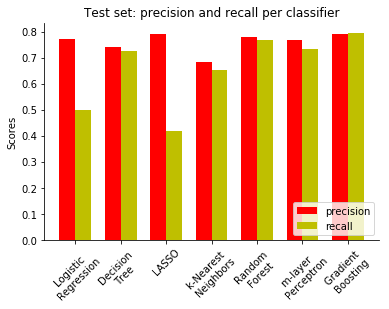

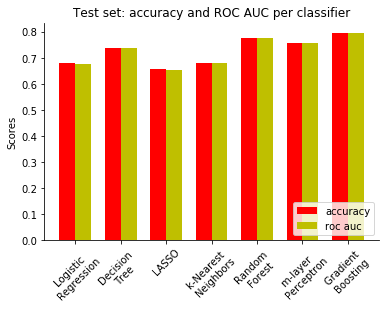

In [43]:
test_precisions = [np.mean(logit_test_precision), np.mean(tree_test_precision),
                   np.mean(lasso_test_precision), np.mean(knn_test_precision),
                   np.mean(forest_test_precision), np.mean(tron_test_precision),
                   np.mean(boost_test_precision)]

test_recalls = [np.mean(logit_test_recall), np.mean(tree_test_recall),
                   np.mean(lasso_test_recall), np.mean(knn_test_recall),
                   np.mean(forest_test_recall), np.mean(tron_test_recall),
                   np.mean(boost_test_recall)]

accuracy = [np.mean(logit_test_acc), np.mean(tree_test_acc),
                   np.mean(lasso_test_acc), np.mean(knn_test_acc),
                   np.mean(forest_test_acc), np.mean(tron_test_acc),
                   np.mean(boost_test_acc)]

roc_auc = [np.mean(logit_test_roc_auc), np.mean(tree_test_roc_auc),
                   np.mean(lasso_test_roc_auc), np.mean(knn_test_roc_auc),
                   np.mean(forest_test_roc_auc), np.mean(tron_test_roc_auc),
                   np.mean(boost_test_roc_auc)]

names = ['Logistic \nRegression', 'Decision \nTree', 'LASSO', 'k-Nearest \nNeighbors', 
         'Random \nForest', 'm-layer \nPerceptron', 'Gradient \nBoosting'] 

print("Precisions and recalls for single models")
plot_precision_recall(test_precisions, test_recalls, accuracy, roc_auc, names)

### Error Analysis

In [52]:
# Split data into 0.8 train and 0.2 test

np.random.seed(seed=13579)

train_idx = np.random.choice(range(len(df_b2_ri_n)), int(len(df_b2_ri_n) * .8), replace=False)
test_idx = list(set(range(len(df_b2_ri_n))) - set(list(train_idx)))

train_x = df_b2_ri_n.loc[train_idx, new_feature_names]
train_y = df_b2_ri_n.loc[train_idx, label_name]
test_x = df_b2_ri_n.loc[test_idx, new_feature_names]
test_y = df_b2_ri_n.loc[test_idx, label_name]

logit = LogisticRegression()
logit.fit(train_x, train_y)

tree = DecisionTreeClassifier(random_state=13579, max_depth=18)
tree.fit(train_x, train_y)

lasso = LogisticRegression(penalty = 'l1')
lasso.fit(train_x, train_y)

knn = KNeighborsClassifier()
knn.fit(train_x, train_y)

forest = RandomForestClassifier(random_state=13579, max_depth=18)
forest.fit(train_x, train_y)

tron = MLPClassifier(solver='lbfgs', random_state=13579)
tron.fit(train_x, train_y)

boost = GradientBoostingClassifier(random_state=13579, max_depth=7)
boost.fit(train_x, train_y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=7,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=13579, subsample=1.0, verbose=0,
              warm_start=False)

In [53]:
test_x.head()

,avg_size,latest_size,total_views,change_in_views_v1_7_30,change_in_views_v1_3_7,change_in_views_v1_1_3,change_in_views_v2_7_30,change_in_views_v2_3_7,change_in_views_v2_1_3,total_edits,...,change_in_talk_edits_v2_7_30,change_in_talk_edits_v2_3_7,change_in_talk_edits_v2_1_3,total_talk_minor_edits,change_in_talk_minor_edits_v1_7_30,change_in_talk_minor_edits_v1_3_7,change_in_talk_minor_edits_v1_1_3,change_in_talk_minor_edits_v2_7_30,change_in_talk_minor_edits_v2_3_7,change_in_talk_minor_edits_v2_1_3
0,-0.052081,-0.057062,-0.134654,-0.010707,-0.003978,0.101153,-0.117923,-0.076264,0.059739,-0.164703,...,-0.018941,-0.016098,-0.019896,-0.074512,0.006581,-0.007118,-0.001864,0.003518,-0.012419,-0.013101
65538,-0.058577,-0.087776,-0.138964,0.003745,-0.009132,0.058864,-0.034524,-0.099102,-0.092772,-0.164703,...,-0.018941,-0.016098,-0.019896,-0.074512,0.006581,-0.007118,-0.001864,0.003518,-0.012419,-0.013101
32772,-0.049208,-0.071577,-0.170759,0.005576,-0.001401,0.074527,-0.069675,-0.142239,0.020706,-0.164703,...,-0.018941,-0.016098,-0.019896,-0.074512,0.006581,-0.007118,-0.001864,0.003518,-0.012419,-0.013101
32773,-0.057520,-0.087729,-0.172387,0.005461,-0.000886,0.077660,-0.090617,-0.158830,0.165131,-0.164703,...,-0.018941,-0.016098,-0.019896,-0.074512,0.006581,-0.007118,-0.001864,0.003518,-0.012419,-0.013101
32776,-0.059897,-0.090443,-0.162236,0.004059,0.002722,0.071395,-0.064844,-0.017368,-0.051507,-0.164703,...,-0.018941,-0.016098,-0.019896,-0.074512,0.006581,-0.007118,-0.001864,0.003518,-0.012419,-0.013101


In [54]:
d_test = {'logit': logit.predict(test_x) == test_y, 
          'tree': tree.predict(test_x) == test_y,
          'lasso': lasso.predict(test_x) == test_y,
          'knn': knn.predict(test_x) == test_y,
          'forest': forest.predict(test_x) == test_y,
          'tron': tron.predict(test_x) == test_y,
          'boost': boost.predict(test_x) == test_y}

df_test = pd.DataFrame(data=d_test)
df_test.head()

,boost,forest,knn,lasso,logit,tree,tron
0,True,True,True,True,True,False,True
65538,True,False,True,False,False,False,True
32772,False,False,True,False,False,False,False
32773,True,True,False,True,True,True,False
32776,False,False,False,False,False,False,False


#### Compare true negatives to false positives and true positives to false negatives

Why weren't false positives classified as negatives (which they really are) and false negatives as positives (which they really are)? As our analysis suggests, false negatives did not provide a clear signal via features to the classifiers. We compared true positives to false negatives along a few significant features and found that misclassified articles indeed are dissimilar to a class they actually belong to. Which is not true for true negatives - false positives pair. Those are very similar, at least across the same set of features.

In [46]:
#type(df_test)
#df_test[2:9]

#DO NOT DELETE - DEPENDENCIES!

misclassified = df_test.loc[(df_test['boost'] == False) & 
            (df_test['forest'] == False) &
            (df_test['knn'] == False) & 
            (df_test['lasso'] == False) &
            (df_test['logit'] == False) & 
            (df_test['tree'] == False) &
            (df_test['tron'] == False)
           ]

classified_correctly = df_test.loc[(df_test['boost'] == True) & 
            (df_test['forest'] == True) &
            (df_test['knn'] == True) & 
            (df_test['lasso'] == True) &
            (df_test['logit'] == True) & 
            (df_test['tree'] == True) &
            (df_test['tron'] == True)
           ]

df_false_true = df_b2_ri_n.copy(deep=True)

df_false = df_false_true.loc[misclassified.index.tolist(),:]

df_true = df_false_true.loc[classified_correctly.index.tolist()]

NameError: name 'df_test' is not defined

In [45]:
#TN vs. FP
t_grouped = df_true.groupby('num_edits_binary')
tn = t_grouped.get_group(0).describe().loc[['mean']].transpose()

significant_features = ['avg_size', 'latest_size', 'total_views', 'total_edits', 
          'change_in_views_v1_3_7', 'change_in_views_v2_3_7',
          'change_in_views_v1_1_3', 'change_in_views_v2_1_3', 
          'change_in_views_v1_7_30', 'change_in_views_v2_7_30']

f_grouped = df_false.groupby('num_edits_binary')
fp = f_grouped.get_group(1).describe().loc[['mean']].transpose()


NameError: name 'df_true' is not defined

In [131]:
#TP vs. FN
t_grouped.get_group(1).describe()

tp = t_grouped.get_group(1).describe().loc[['mean']].transpose()

fn = f_grouped.get_group(0).describe().loc[['mean']].transpose()

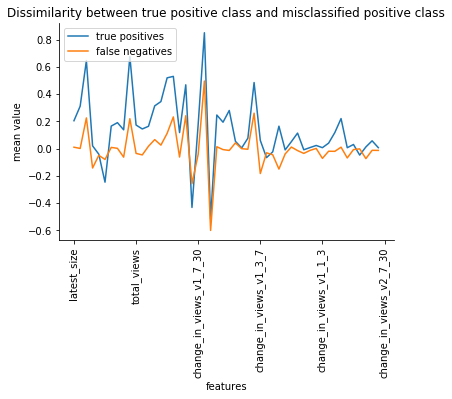

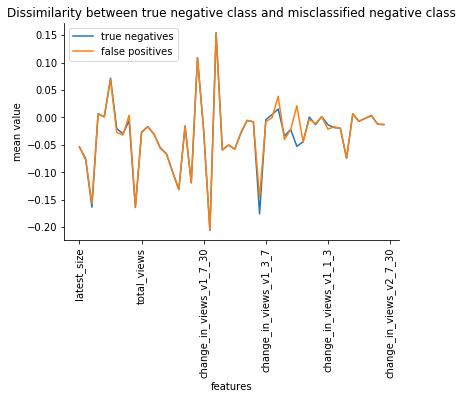

In [140]:
tp_plot = [x for x in tp['mean']]
fn_plot = [x for x in fn['mean']]
tn_plot = [x for x in tn['mean']]
fp_plot = [x for x in fp['mean']]

features = tp.index.tolist()

def plot_dissimilarity(true, false, true_label, false_label, features, title):
    fig, ax = plt.subplots()
    plt.plot(true)
    plt.plot(false)
    plt.legend([true_label, false_label], loc='upper left')
    ax.set_ylabel('mean value')
    ax.set_xlabel('features')
    ax.set_title(title)
    plt.xticks(np.arange(len(features)), features, rotation=90)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()
   
    
plot_dissimilarity(tp_plot[:-1], fn_plot[:-1], 'true positives', 'false negatives', 
                   features[:-1], 'Dissimilarity between true positive class and misclassified positive class')
plot_dissimilarity(tn_plot[:-1], fp_plot[:-1], 'true negatives', 'false positives', 
                   features[:-1], 'Dissimilarity between true negative class and misclassified negative class')

#### Now, let's look at how similar are the misclassified datapoints to those they were taken for

Let's comare false positives to true positives and false negatives to true negatives.

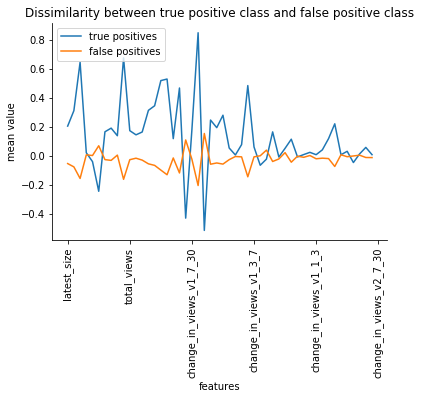

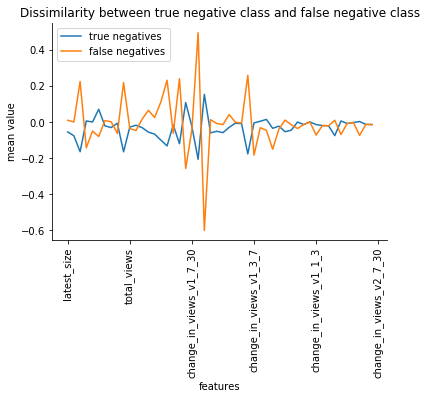

In [133]:
plot_dissimilarity(tp_plot[:-1], fp_plot[:-1], 'true positives', 'false positives', 
                   features[:-1], 'Dissimilarity between true positive class and false positive class')
plot_dissimilarity(tn_plot[:-1], fn_plot[:-1], 'true negatives', 'false negatives', 
                   features[:-1], 'Dissimilarity between true negative class and false negative class')

#### How much overlap in predictions is there among the classifiers?

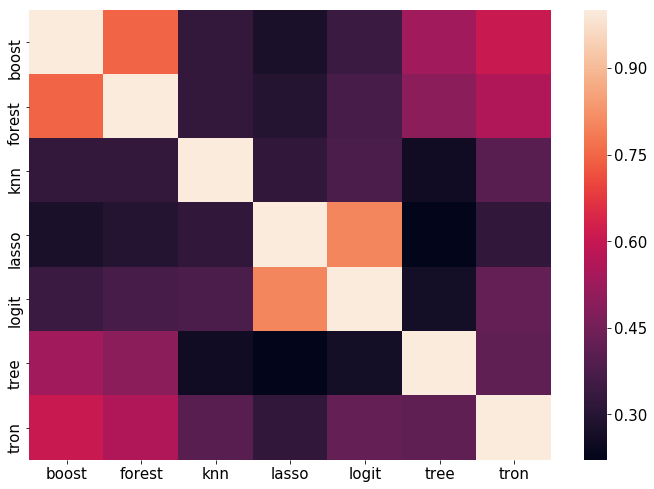

In [111]:
corr = df_test.corr()

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)

plt.rcParams.update({'font.size': 15})

sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            ax = ax)
plt.show()

From the heatmap above we can see that there is around 75% overlap in the predictions made by RandomForest and GradientBoosting, while LASSO and DecisionTree have less than 30% overlap.

### Feature importances

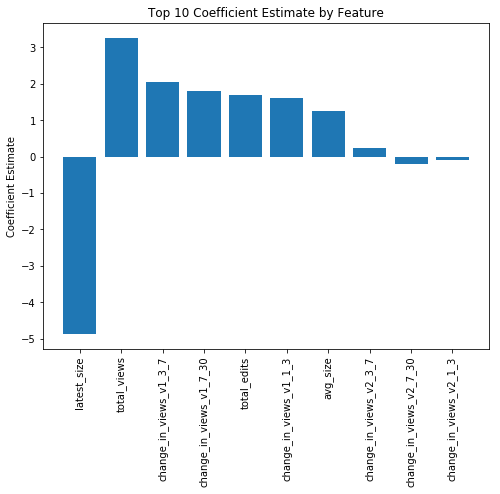

In [136]:
plot_lim = 10

# Logistic regression

logit = LogisticRegression()
logit.fit(train_x, train_y)

logit_coefficients = logit.coef_

#ax = plt.gca()
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)

_, sort_i = list(zip(*sorted(zip(np.abs(logit_coefficients[0]), range(plot_lim)), reverse=True)))
coefs = [logit_coefficients[0][i] for i in sort_i]
sorted_cols = [train_x.columns[i] for i in sort_i]
plt.bar(range(plot_lim), coefs, align='center')
plt.xticks(range(plot_lim), sorted_cols, rotation='vertical')
ax.set_ylabel('Coefficient Estimate')
ax.set_title('Top 10 Coefficient Estimate by Feature')

#fig_size = plt.rcParams["figure.figsize"]
#fig_size[0] = 24
#fig_size[1] = 18
#plt.rcParams["figure.figsize"] = fig_size

plt.rcParams.update({'font.size': 10})

plt.show()

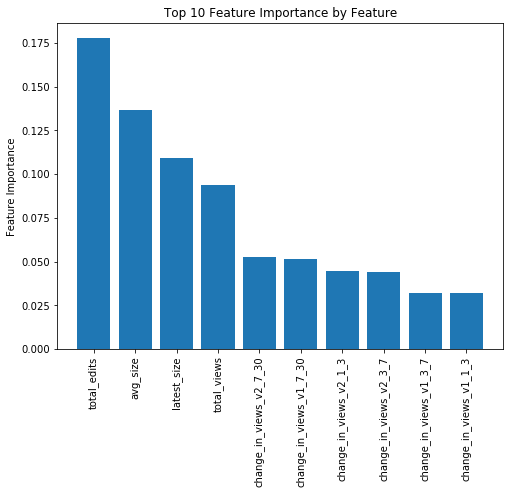

In [137]:
# Decision tree

tree = DecisionTreeClassifier(random_state=13579)
tree.fit(train_x, train_y)

feature_importances = tree.feature_importances_

#ax = plt.gca()
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)

_, sort_i = list(zip(*sorted(zip(feature_importances, range(plot_lim)), reverse=True)))
sorted_feature_importances = [feature_importances[i] for i in sort_i]
sorted_cols = [train_x.columns[i] for i in sort_i]
plt.bar(range(plot_lim), sorted_feature_importances, align='center')
plt.xticks(range(plot_lim), sorted_cols, rotation='vertical')
ax.set_ylabel('Feature Importance')
ax.set_title('Top 10 Feature Importance by Feature')

#fig_size = plt.rcParams["figure.figsize"]
#fig_size[0] = 24
#fig_size[1] = 18
#plt.rcParams["figure.figsize"] = fig_size

plt.rcParams.update({'font.size': 10})

plt.show()

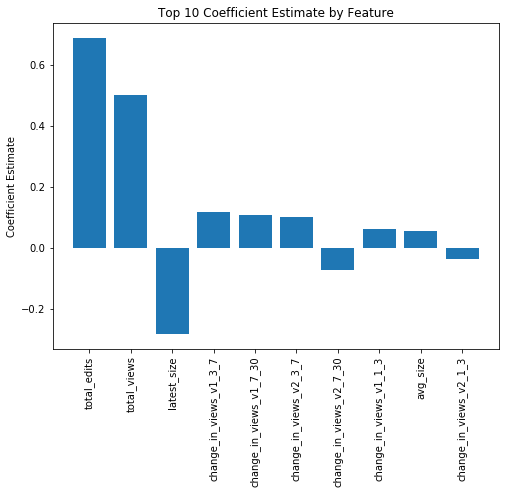

In [138]:
# LASSO

lasso = LogisticRegression(penalty = 'l1')
lasso.fit(train_x, train_y)

lasso_coefficients = lasso.coef_

#ax = plt.gca()
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)

_, sort_i = list(zip(*sorted(zip(np.abs(lasso_coefficients[0]), range(plot_lim)), reverse=True)))
sorted_coefs = [lasso_coefficients[0][i] for i in sort_i]
sorted_cols = [train_x.columns[i] for i in sort_i]

plt.bar(range(plot_lim), sorted_coefs, align='center')
plt.xticks(range(plot_lim), sorted_cols, rotation='vertical')
ax.set_ylabel('Coefficient Estimate')
ax.set_title('Top 10 Coefficient Estimate by Feature')

#fig_size = plt.rcParams["figure.figsize"]
#fig_size[0] = 24
#fig_size[1] = 18
#plt.rcParams["figure.figsize"] = fig_size

plt.rcParams.update({'font.size': 10})

plt.show()

In [ ]:
# K-nearest neighbors (TAKES FOREVER TO RUN, IGNORE FOR NOW)
# TODO: Update to grab just top 10 features.

np.random.seed(seed=13579)

knn = KNeighborsClassifier()

knn_features = features
knn_target = 'num_edits_binary'

old_vars = []

final_lst = []

while len(knn_features) > 0:
    one_run = []
    for feature in knn_features:
        one_run += [[np.mean(cross_val_score(knn, 
                                             df_b2_ri_n[old_vars + [feature]], 
                                             df_b2_ri_n[target], 
                                             cv=2)), 
                     feature]]
    one_run.sort(key = lambda x: x[0], reverse=True)
    final_lst += [one_run[0]]
    old_vars += [one_run[0][1]]
    knn_features = [f for f in knn_features if f != one_run[0][1]]
    if len(final_lst) >= 2 and final_lst[-1][0] < final_lst[-2][0]:
        final_lst = final_lst[:-1]
        break

plt.plot([i for i in range(len(final_lst))],
            [final_lst[i][0] for i in range(len(final_lst))], "-o")

labels = [final_lst[i][1] for i in range(len(final_lst))]

plt.xticks([i for i in range(len(final_lst))], 
           labels, rotation='vertical')

plt.ylabel("Accuracy")
plt.title("Forward Selection")

plt.show()

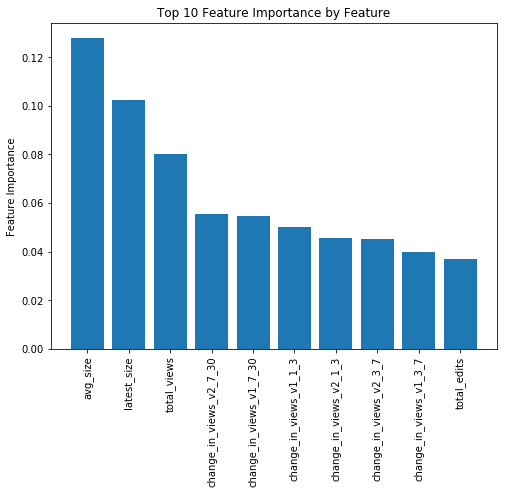

In [139]:
# Random forest

forest = RandomForestClassifier(random_state=13579)
forest.fit(train_x, train_y)

feature_importances = forest.feature_importances_
_, sort_i = list(zip(*sorted(zip(feature_importances, range(plot_lim)), reverse=True)))
sorted_feature_importances = [feature_importances[i] for i in sort_i]
sorted_cols = [train_x.columns[i] for i in sort_i]

#ax = plt.gca()
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)

plt.bar(range(plot_lim), sorted_feature_importances, align='center')
plt.xticks(range(plot_lim), sorted_cols, rotation='vertical')
ax.set_ylabel('Feature Importance')
ax.set_title('Top 10 Feature Importance by Feature')

#fig_size = plt.rcParams["figure.figsize"]
#fig_size[0] = 24
#fig_size[1] = 18
#plt.rcParams["figure.figsize"] = fig_size

plt.rcParams.update({'font.size': 10})

plt.show()

In [ ]:
# Multi-layer perceptron (TAKES FOREVER TO RUN, IGNORE FOR NOW)
# TODO: Update to grab just top 10 features.

tron_features = features
tron_target = 'num_edits_binary'

final_lst = []

while len(tron_features) > 1:
    one_run = []
    for feature in tron_features:
        tron = MLPClassifier(solver='lbfgs', random_state=13579)
        one_run += [[np.mean(cross_val_score(tron, 
                                             df_b2_ri_n[list(set(tron_features) - set([feature]))], 
                                             df_b2_ri_n[tron_target], 
                                             cv=2)), 
                     feature]]
    one_run.sort(key = lambda x: x[0])
    final_lst += [one_run[0]]
    tron_features = [f for f in tron_features if f != one_run[0][1]]
    print(tron_features)

plt.plot([i for i in range(len(final_lst))],
            [final_lst[i][0] for i in range(len(final_lst))], "-o")

labels = [final_lst[i][1] for i in range(len(final_lst))]

plt.xticks([i for i in range(len(final_lst))], 
           labels, rotation='vertical')

plt.ylabel("Accuracy")
plt.title("Backward Selection")

plt.show()

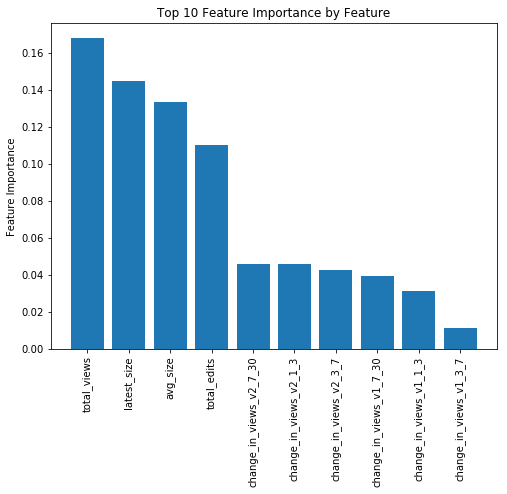

In [140]:
# Gradient boosting

boost = GradientBoostingClassifier(random_state=13579)
boost.fit(train_x, train_y)

feature_importances = boost.feature_importances_
_, sort_i = list(zip(*sorted(zip(feature_importances, range(plot_lim)), reverse=True)))
sorted_feature_importances = [feature_importances[i] for i in sort_i]
sorted_cols = [train_x.columns[i] for i in sort_i]

#ax = plt.gca()
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)

plt.bar(range(plot_lim), sorted_feature_importances, align='center')
plt.xticks(range(plot_lim), sorted_cols, rotation='vertical')
ax.set_ylabel('Feature Importance')
ax.set_title('Top 10 Feature Importance by Feature')

#fig_size = plt.rcParams["figure.figsize"]
#fig_size[0] = 24
#fig_size[1] = 18
#plt.rcParams["figure.figsize"] = fig_size

plt.rcParams.update({'font.size': 10})

plt.show()

* It seems like for different models, different features are more important. Very often, it is total_views, total_talk_views, total_edits, as well as avg_size and latest_size (but not for lasso and logistic regression). 

* We can try some dimensionality reduction techniques, like principal component analysis (PCA) to see if it is possible to cut on the number of features without damage to explained variance.

#### Check if there is a case for feature reduction

In [126]:
# We'll use Minka’s MLE to guess the dimensions

pca = PCA(n_components='mle', svd_solver='full')
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components='mle', random_state=None,
  svd_solver='full', tol=0.0, whiten=False)

In [127]:
print("initial number of features: ", len(new_feature_names))

initial number of features:  50


In [128]:
print("after dimensionality resuction: ", pca.n_components_)

after dimensionality resuction:  49


The PCA results suggest that ~50 is the reasonable number of features for this data set. This is an expected result, since our data is not very sparse (sparsity is one use case for PCA), and 50 dimensions is not too much (high dimensionality - another use case). 

## GradientBoosting: exploration, error analysis, imbalanced set testing 

GradientBoosting remains the best fit for our data, and even our ensemble is not outperforming GB.

So let's explore GB output and do some error analysis.

In [52]:
''' TP, FN
    FP, TN'''

array = np.zeros((2,2))
array[0,0] = confusion_string[-1]
array[0,1] = confusion_string[2]
array[1,0] = confusion_string[1]
array[1,1] = confusion_string[0]

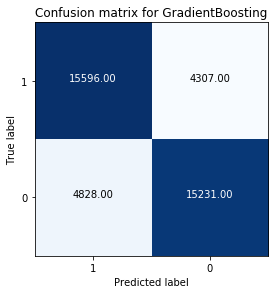

In [53]:
def plot_confusion_matrix(matrix, title, classes, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

np.set_printoptions(precision=2)

plot_confusion_matrix(array, 'Confusion matrix for GradientBoosting', [1,0])

plt.show()

In [141]:
GB_misclassified = df_test['boost'].loc[(df_test['boost'] == False)]
GB_classified_correctly = df_test['boost'].loc[(df_test['boost'] == True)]



In [47]:
## uncomment if line charts for multi-model error analysis got deleted

#df_false_true = df_b2_ri_n.copy(deep=True)

In [144]:
gb_false = df_false_true.loc[GB_misclassified.index.tolist(),:]
gb_true = df_false_true.loc[GB_classified_correctly.index.tolist()]

In [ ]:
gb_t_grouped = gb_true.groupby('num_edits_binary')
gb_tn = gb_t_grouped[significant_features].get_group(0).describe().loc[['mean']].transpose()
gb_tp = gb_t_grouped[significant_features].get_group(1).describe().loc[['mean']].transpose()
gb_f_grouped = gb_false.groupby('num_edits_binary')
gb_fp = gb_f_grouped[significant_features].get_group(1).describe().loc[['mean']].transpose()
gb_fn = gb_f_grouped[significant_features].get_group(0).describe().loc[['mean']].transpose()

In [27]:
significant_features = ['avg_size', 'latest_size', 'total_views', 'total_edits', 
          'change_in_views_v1_3_7', 'change_in_views_v2_3_7',
          'change_in_views_v1_1_3', 'change_in_views_v2_1_3', 
          'change_in_views_v1_7_30', 'change_in_views_v2_7_30']

In [ ]:
gb_tp_plot = [x for x in gb_tp['mean']]
gb_fn_plot = [x for x in gb_fn['mean']]
gb_tn_plot = [x for x in gb_tn['mean']]
gb_fp_plot = [x for x in gb_fp['mean']]

In [43]:
def plot_dissimilarity(true, false, true_label, false_label, features, title):
    fig, ax = plt.subplots()
    plt.plot(true)
    plt.plot(false)
    plt.legend([true_label, false_label], loc='upper left')
    ax.set_ylabel('mean value')
    ax.set_xlabel('features')
    ax.set_title(title)
    plt.xticks(np.arange(len(features)), features, rotation=90)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()
   

In [35]:
    
plot_dissimilarity(gb_tp_plot, gb_fn_plot, 'true positives', 'false negatives', 
                   significant_features, 'Dissimilarity between true positive class and misclassified positive class')
plot_dissimilarity(gb_tn_plot, gb_fp_plot, 'true negatives', 'false positives', 
                   significant_features, 'Dissimilarity between true negative class and misclassified negative class')

NameError: name 'gb_tp_plot' is not defined

### Imbalanced set exploration, GradientBoosting

In [49]:
# test GB on imbalanced set

y_pred_test_imb = boost.predict(imb_X)

confusion = confusion_matrix(imb_Y, y_pred_test_imb).ravel()

print("GB for imbalanced set:")
print("Test accuracy is ", accuracy_score(imb_Y, y_pred_test_imb))
print("Test precision is ", precision_score(imb_Y, y_pred_test_imb))
print("Test recall is ", recall_score(imb_Y, y_pred_test_imb))
print("Test ROC AUC is ", roc_auc_score(imb_Y, y_pred_test_imb))
print("TN, FP, FN, TP ", confusion)


imb_d_test = {'boost': y_pred_test_imb == imb_Y}

imb_df_test = pd.DataFrame(data=imb_d_test)
imb_df_test.head()

imb_GB_misclassified = imb_df_test['boost'].loc[(imb_df_test['boost'] == False)]
imb_GB_classified_correctly = imb_df_test['boost'].loc[(imb_df_test['boost'] == True)]

GB for imbalanced set:
Test accuracy is  0.0244889971813
Test precision is  0.000826065470075
Test recall is  0.9712358659
Test ROC AUC is  0.497469031088
TN, FP, FN, TP  [ 143772 5921995     145    4896]


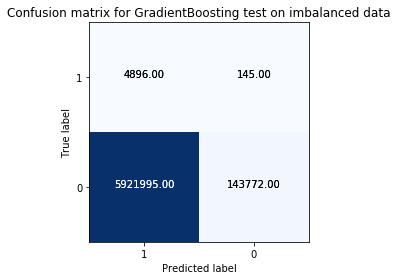

In [56]:
''' TP, FN
    FP, TN'''

matrix = np.zeros((2,2))
matrix[0,0] = confusion[-1]
matrix[0,1] = confusion[2]
matrix[1,0] = confusion[1]
matrix[1,1] = confusion[0]

plot_confusion_matrix(matrix, 'Confusion matrix for GradientBoosting test on imbalanced data', [1,0])
plt.show()

**Most of the incorrect predictions for imbalanced set fall into false positives** 

In [28]:
imb_df_false_true = df_imb2_ri_n.copy(deep=True)

imb_gb_false = imb_df_false_true.loc[imb_GB_misclassified.index.tolist(),:]
imb_gb_true = imb_df_false_true.loc[imb_GB_classified_correctly.index.tolist()]

imb_gb_t_grouped = imb_gb_true.groupby('num_edits_binary')
imb_gb_tn = imb_gb_t_grouped[significant_features].get_group(0).describe().loc[['mean']].transpose()
imb_gb_tp = imb_gb_t_grouped[significant_features].get_group(1).describe().loc[['mean']].transpose()
imb_gb_f_grouped = imb_gb_false.groupby('num_edits_binary')
imb_gb_fp = imb_gb_f_grouped[significant_features].get_group(1).describe().loc[['mean']].transpose()
imb_gb_fn = imb_gb_f_grouped[significant_features].get_group(0).describe().loc[['mean']].transpose()

imb_gb_tp_plot = [x for x in imb_gb_tp['mean']]
imb_gb_fn_plot = [x for x in imb_gb_fn['mean']]
imb_gb_tn_plot = [x for x in imb_gb_tn['mean']]
imb_gb_fp_plot = [x for x in imb_gb_fp['mean']]


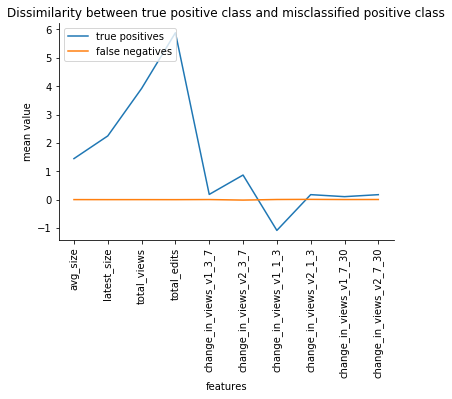

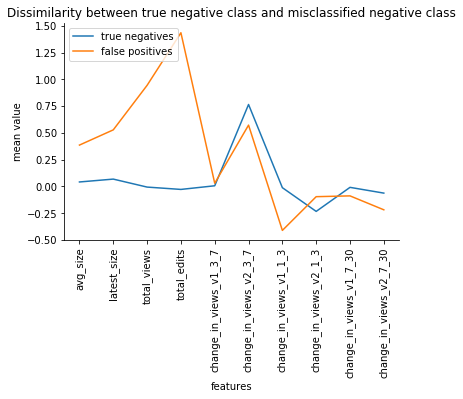

In [44]:
plot_dissimilarity(imb_gb_tp_plot, imb_gb_fn_plot, 'true positives', 'false negatives', 
                   significant_features, 'Dissimilarity between true positive class and misclassified positive class')
plot_dissimilarity(imb_gb_tn_plot, imb_gb_fp_plot, 'true negatives', 'false positives', 
                   significant_features, 'Dissimilarity between true negative class and misclassified negative class')